# Setup

Importing libraries, reaading the dataframe from the excel file and setting seed for reproducibility

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('BankClients.xlsx')

seed = 69

# Data preprocessing

Deleting first column (index) which is useful for clusterization

In [2]:
df.drop(labels = 'ID', axis = 1, inplace = True)

Splitting the original dataframe into one containing the numerical features and another containing the categorical ones

In [3]:
df_num = df[['Age', 'Income', 'Wealth', 'Debt', 'FinEdu', 'ESG', 'Digital', 'BankFriend', 'LifeStyle', 'Luxury', 'Saving', 'FamilySize']]
df_cat = df[['Gender', 'Job', 'Area', 'CitySize', 'Investments']]

Transforming the categorical dataframe into a dummy features (one-hot encoding) dataframe

In [4]:
df_dummy = pd.DataFrame()
for columns in df_cat.columns:
    df_temp = pd.get_dummies(df_cat[columns])
    df_temp.columns = [columns + str(x) for x in df_temp.columns]
    df_dummy = pd.concat([df_dummy, df_temp], axis = 1)

Creating the final dataframe containing one-hot encoded features and numerical features

In [5]:
df = pd.concat([df_dummy, df_num], axis = 1)

MinMax scaling the data (feature-wise)

In [6]:
for c in df.columns:
    df[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

Selecting a random subsample of data to use for clustering

In [7]:
data = df.sample(frac = 0.2, random_state = seed).to_numpy()

# Data exploration

Defining the function to compute the distance: <code>hamming</code> for categorical values and <code>L1</code> for numerical values

In [9]:
from scipy.spatial.distance import cdist

def mixed_distance(A, B):
    nFeat = 28
    nCat = 16
    A = A.reshape(1,-1)
    B = B.reshape(1,-1)
    dCat = cdist(A[:, :nCat], B[:, :nCat], 'hamming')
    dNum = cdist(A[:, nCat:], B[:, nCat:], 'cityblock')
    wCat = float(nCat) / (float(nFeat))
    d = wCat * dCat + (1 - wCat) * dNum
    return d

## tSNE
There are two main hyperparameters for tSNE (in addition to the dimensionality of the final representation), 
which are the perplexity and the learning rate. Perplexity defines the balance attention between local 
and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors 
each point has. Initially we fix the learning rate to the default value (200) and apply tSNE with different
perplexity values. Then we fix the perplexity to the value which yielded the best results (in terms of clustering)
and apply tSNE with different learning rates.

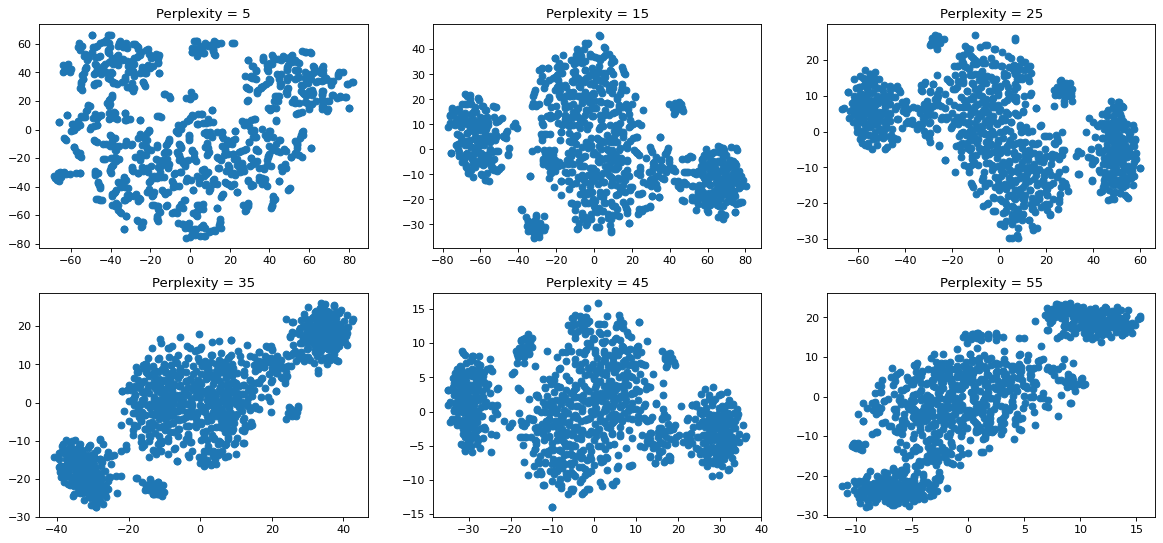

In [9]:
from sklearn.manifold import TSNE

# usual values for perplexity are in the range (5, 50) so we define a range (5, 55) with step = 10
initial_perplexity = 5
final_perplexity = 55
step = 10

learning_rate = 200 #default value
dimensions = 2

# defining the matplotlib object that contains multiple plots
fig, axes = plt.subplots(2, 3, figsize=(18,8), dpi=80)
row = 0
column = 0

# for each perplexity value we apply tsne and plot the results
for perplexity in range(initial_perplexity, final_perplexity + 1, step):
  tsne = TSNE(n_components=dimensions,
              perplexity=perplexity,
              learning_rate=learning_rate,
              metric=mixed_distance,
              random_state=seed)
  X_tsne = tsne.fit_transform(data)
  ax = axes[row][column]
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
  ax.set_title(f'Perplexity = {perplexity}')
  column = column + 1
  if column % 3 == 0:
    column = 0
    row = row + 1 

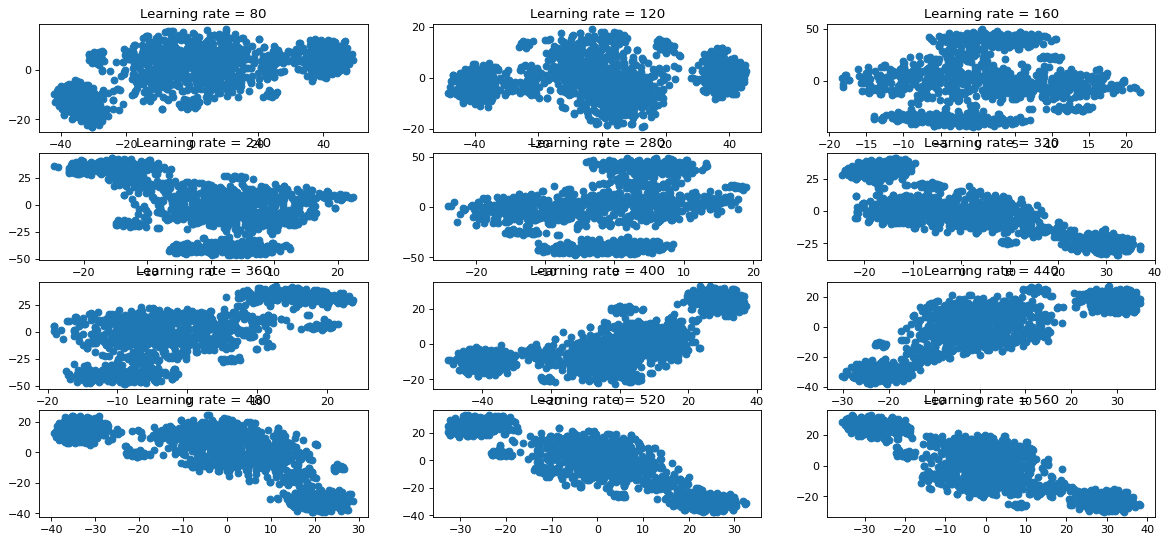

In [10]:
# here we fix the perplexity to 35 and try different learning rates

learning_rate_vector = np.array([80, 120, 160, 240, 280, 320, 360, 400, 440, 480, 520, 560])

perplexity = 35 #best value from past cell
dimensions = 2

fig, axes = plt.subplots(4, 3, figsize=(18,20), dpi=80)
row = 0
column = 0

for learning_rate in learning_rate_vector:
  tsne = TSNE(n_components=dimensions,
              perplexity=perplexity,
              learning_rate=learning_rate,
              metric=mixed_distance,
              random_state=seed)
  X_tsne = tsne.fit_transform(data)
  ax = axes[row][column]
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
  ax.set_title(f'Learning rate = {learning_rate}')
  column = column + 1
  if column % 3 == 0:
    column = 0
    row = row + 1 

## PCA
Applying the Principal Component Analysis to the numerical features

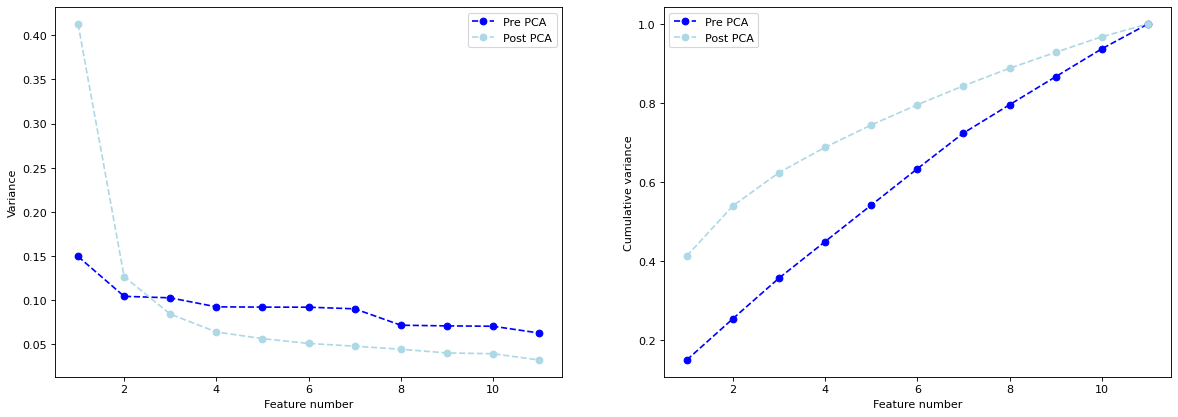

In [23]:
from sklearn.decomposition import PCA

num_data = data[:, 19:]

# calculating quantities related to data before applying PCA
cov = np.cov(num_data.T) / np.trace(np.cov(num_data.T))
var = np.flip(np.sort(np.diag(cov)))
cumulative = np.empty(var.shape)
for i in range(var.shape[0]):
    cumulative[i] = sum(var[:i+1])

# applying PCA
pca = PCA(n_components = num_data.shape[1], random_state = seed)
pca.fit(num_data)
pca_data = pca.transform(num_data)

# calculating quantities related to data after applying PCA
pca_cov = np.cov(pca_data.T) / np.trace(np.cov(num_data.T))
pca_var = np.flip(np.sort(np.diag(pca_cov)))
pca_cumulative = np.empty(pca_var.shape)
for i in range(pca_var.shape[0]):
    pca_cumulative[i] = sum(pca_var[:i+1])

x = np.arange(1, var.shape[0] + 1)

fig, axes = plt.subplots(1, 2, figsize=(18,6), dpi=80)

ax = axes[0]
ax.plot(x, var, 'o--', color = 'blue', label = 'Pre PCA')
ax.plot(x, pca_var, 'o--', color = 'lightblue', label = 'Post PCA')
ax.set_xlabel('Feature number')
ax.set_ylabel('Variance')
ax.legend()

ax = axes[1]
ax.plot(x, cumulative, 'o--', color = 'blue', label = 'Pre PCA')
ax.plot(x, pca_cumulative, 'o--', color = 'lightblue', label = 'Post PCA')
ax.set_xlabel('Feature number')
ax.set_ylabel('Cumulative variance')
ax.legend()

plt.show()

# Clustering

## k-medoids clustering 
Trying <code>k</code> values between <code>k_min</code> and <code>k_max</code> and computing the silhouette, Calinski-Harabasz and Davies-Bouldin metrics for each <code>k</code> value

In [12]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

k_min = 2
k_max = 6
k_vector = np.arange(k_min, k_max + 1, 1)
silhouette = np.empty(k_vector.shape)
ch_score = np.empty(k_vector.shape)
db_score = np.empty(k_vector.shape)
for k in k_vector:
    kmedoids = KMedoids(n_clusters = k, metric = mixed_distance, random_state = seed).fit(data)
    silhouette[k - k_min] = silhouette_score(data, kmedoids.labels_, metric = mixed_distance, random_state = seed)
    ch_score[k - k_min] = calinski_harabasz_score(data, kmedoids.labels_)
    db_score[k - k_min] = davies_bouldin_score(data, kmedoids.labels_)

# Here we should try different metrics for clustering evaluation!

Plotting silhouette, Calinski-Harabasz and Davies-Bouldin metrics as a function of <code>k</code>

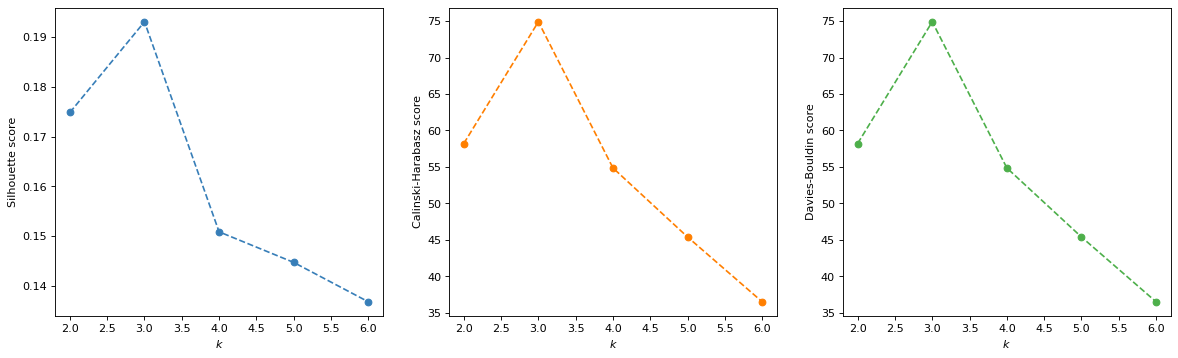

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(k_vector, silhouette, 'o--', color = '#377eb8')
ax.set_xlabel('$k$')
ax.set_ylabel('Silhouette score')

ax = axes[1]
ax.plot(k_vector, ch_score, 'o--', color = '#ff7f00')
ax.set_xlabel('$k$')
ax.set_ylabel('Calinski-Harabasz score')

ax = axes[2]
ax.plot(k_vector, db_score, 'o--', color = '#4daf4a')
ax.set_xlabel('$k$')
ax.set_ylabel('Davies-Bouldin score')

plt.show()

Selecting <code>k=3</code> as the best <code>k</code> for k-medoids (from metric values) and plotting the results in tSNE representation. We try different values for perplexity and learning rate for tSNE.

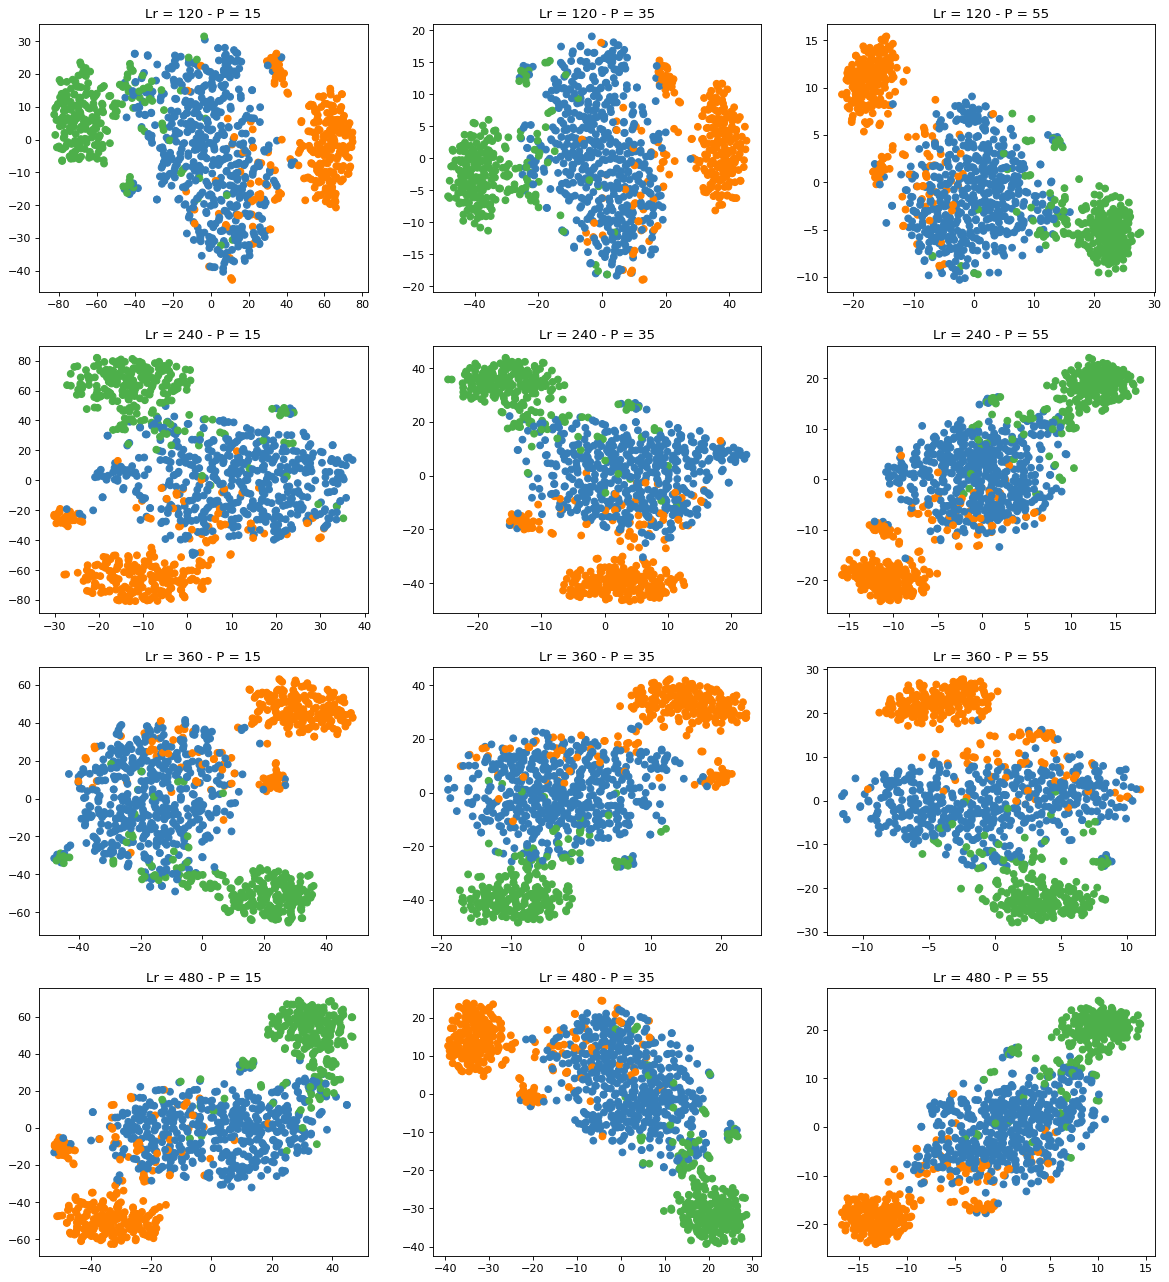

In [14]:
kmedoids = KMedoids(n_clusters = 3, metric = mixed_distance, random_state = seed).fit(data) # k=3 is the best from previous graph

# defining the values for learning rate and perplexity that are going to be tested
perplexity_vector = np.array([15, 35, 55])
learning_rate_vector = np.array([120, 240, 360, 480])
dimensions = 2

# defining the 'colors' list that is going to be used to assign a different color to each data point in the plot
color_list = ['#377eb8', '#ff7f00', '#4daf4a']
colors = []
for i in kmedoids.labels_:
   colors.append(color_list[i])

fig, axes = plt.subplots(4, 3, figsize=(18,20), dpi=80)
row = 0
column = 0

for learning_rate in learning_rate_vector:
  for perplexity in perplexity_vector:
    tsne = TSNE(n_components=dimensions,
                perplexity=perplexity,
                learning_rate=learning_rate,
                metric=mixed_distance,
                random_state=seed)
    X_tsne = tsne.fit_transform(data)
    ax = axes[row][column]
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
    ax.set_title(f'Lr = {learning_rate} - P = {perplexity}')
    column = column + 1
    if column % 3 == 0:
        column = 0
        row = row + 1 

Plotting clusters projecting them in a 2D feature space (e.g. <code>Age</code> (19th feature) vs <code>Wealth</code> (21st feature))

In [ ]:
""" feature_1 = 19
feature_2 = 21

labels = kmedoids.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
  class_member_mask = labels == k
  xy = data[class_member_mask]
  plt.plot(
    xy[:, feature_1],
    xy[:, feature_2],
    "o",
    markerfacecolor=tuple(col),
    markeredgecolor="k",
    markersize=6,
  )

  plt.plot(
    kmedoids.cluster_centers_[:, feature_1],
    kmedoids.cluster_centers_[:, feature_2],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
  )

plt.title("KMedoids clustering. Medoids are represented in cyan.")
plt.show() """

## DBSCAN
A fundamental hyperparameter in DBSCAN clustering is <code>eps</code>, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. To have an idea of the order of magnitude of this value, the average distance between data points using <code>mixed_metric</code> is computed.

In [16]:
avg_distance = np.array([[0.0]])
samples = 0.0

for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        samples = samples + 1
        avg_distance = avg_distance + mixed_distance(data[i], data[j])

avg_distance = avg_distance / samples
print(avg_distance)

[[1.19837354]]


This algorithm is not working too well with this data. With several values of the parameters two extreme cases show up:
- The points are all clustered in only one class (with the exception of some outliers);
- A small portion of points are clustered, the majority of them are labeled as outliers.

For this reason filtering has been implemented in order to deal with these cases.

In [11]:
from math import floor
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

initial_eps = 0.4
final_eps = 0.6
step_eps = 0.1

initial_min_samples = 3
final_min_samples = 7
step_min_samples = 1

eps_vector = np.arange(initial_eps, final_eps + step_eps, step_eps)
min_samples_vector = np.arange(initial_min_samples, final_min_samples + step_min_samples, step_min_samples)

silhouette_list = []
db_list = []
ch_list = []
outliers_number_list = []
eps_list = []
min_samples_list = []
outliers_threshold = 95
dbscan_labels = np.empty((eps_vector.shape[0] * min_samples_vector.shape[0], data.shape[0]))
count = 0

for eps in eps_vector:
    for min_samples in min_samples_vector:
        temp_labels = DBSCAN(eps=eps, min_samples=min_samples, metric=mixed_distance).fit_predict(data)

        is_outlier = temp_labels == -1
        is_not_outlier = temp_labels != -1
        unique_labels = np.unique(temp_labels[is_not_outlier]).shape[0]
        # not good labels = only one class or more than ten classes
        is_not_good_labels = (unique_labels < 2) or (unique_labels > 10)
        outliers_percentage = floor(float(temp_labels[is_outlier].shape[0]) / float(data.shape[0]) * 100.0)

        if is_not_good_labels or (outliers_percentage > outliers_threshold):
            continue

        eps_list.append(eps)
        min_samples_list.append(min_samples)
        outliers_number_list.append(outliers_percentage)
        dbscan_labels[count, :] = np.copy(temp_labels)
        count = count + 1

        silhouette_list.append(silhouette_score(data[is_not_outlier], 
                                                temp_labels[is_not_outlier], 
                                                metric = mixed_distance, 
                                                random_state = seed))
        
        db_list.append(davies_bouldin_score(data[is_not_outlier], 
                                            temp_labels[is_not_outlier]))
        
        ch_list.append(calinski_harabasz_score(data[is_not_outlier], 
                                               temp_labels[is_not_outlier]))

In [13]:
print(eps_list)
print(min_samples_list)

[0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.6]
[4, 5, 6, 7, 4, 5, 6, 7, 3]


Plotting silhouette as a function of <code>eps</code> and <code>min_samples</code> hyperparameters, showing also the percentage of outliers

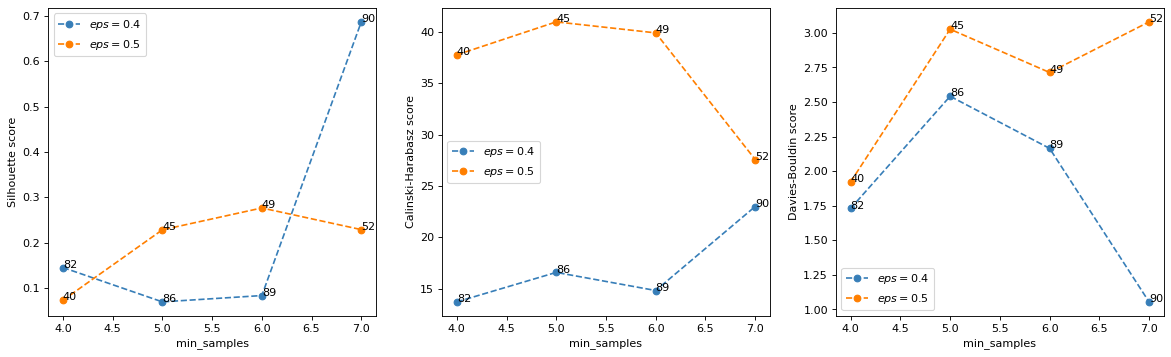

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(min_samples_list[:4], silhouette_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], silhouette_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Silhouette score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], silhouette_list[i]))
ax.legend()

ax = axes[1]
ax.plot(min_samples_list[:4], ch_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], ch_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Calinski-Harabasz score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], ch_list[i]))
ax.legend()

ax = axes[2]
ax.plot(min_samples_list[:4], db_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], db_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Davies-Bouldin score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], db_list[i]))
ax.legend()

plt.show()

Plotting DBSCAN results in tSNE representation

In [17]:
labels = DBSCAN(eps=0.5, min_samples=5, metric=mixed_distance).fit_predict(data)
is_not_outlier = labels != -1
unique_labels = np.unique(labels[is_not_outlier]).shape[0]
print(unique_labels)

Text(0.5, 1.0, 'Lr = 480 - P = 35')

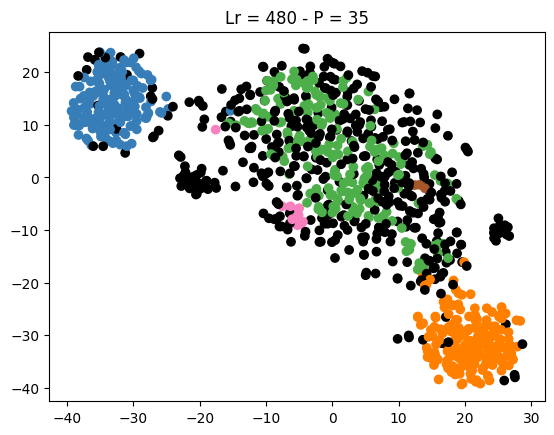

In [24]:
from sklearn.manifold import TSNE

color_list = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', 'black']
colors = []
for i in labels:
   colors.append(color_list[i])

tsne = TSNE(n_components=2,
            perplexity=35,
            learning_rate=480,
            metric=mixed_distance,
            random_state=seed)
X_tsne = tsne.fit_transform(data)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
plt.title(f'Lr = 480 - P = 35')
plt.show()

## OPTICS
Same procedure as for DBSCAN

In [25]:
from math import floor
from sklearn.cluster import OPTICS

initial_eps = 0.4
final_eps = 0.6
step_eps = 0.1

initial_min_samples = 4
final_min_samples = 7
step_min_samples = 1

eps_vector = np.arange(initial_eps, final_eps + step_eps, step_eps)
min_samples_vector = np.arange(initial_min_samples, final_min_samples + step_min_samples, step_min_samples)

silhouette_list = []
db_list = []
ch_list = []
outliers_number_list = []
eps_list = []
min_samples_list = []
outliers_threshold = 95
optics_labels = np.empty((eps_vector.shape[0] * min_samples_vector.shape[0], data.shape[0]))
count = 0

for eps in eps_vector:
    for min_samples in min_samples_vector:
        temp_labels = OPTICS(eps=eps, min_samples=min_samples, metric=mixed_distance).fit_predict(data)

        is_outlier = temp_labels == -1
        is_not_outlier = temp_labels != -1
        unique_labels = np.unique(temp_labels[is_not_outlier]).shape[0]
        # not good labels = only one class or more than ten classes
        is_not_good_labels = (unique_labels < 2) or (unique_labels > 10)
        outliers_percentage = floor(float(temp_labels[is_outlier].shape[0]) / float(data.shape[0]) * 100.0)

        if is_not_good_labels or (outliers_percentage > outliers_threshold):
            continue

        eps_list.append(eps)
        min_samples_list.append(min_samples)
        outliers_number_list.append(outliers_percentage)
        optics_labels[count, :] = np.copy(temp_labels)
        count = count + 1

        silhouette_list.append(silhouette_score(data[is_not_outlier], 
                                                temp_labels[is_not_outlier], 
                                                metric = mixed_distance, 
                                                random_state = seed))
        
        db_list.append(davies_bouldin_score(data[is_not_outlier], 
                                            temp_labels[is_not_outlier]))
        
        ch_list.append(calinski_harabasz_score(data[is_not_outlier], 
                                               temp_labels[is_not_outlier]))

In [26]:
print(eps_list)
print(min_samples_list)

[]
[]


In [ ]:
""" fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(min_samples_list[:4], silhouette_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], silhouette_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Silhouette score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], silhouette_list[i]))
ax.legend()

ax = axes[1]
ax.plot(min_samples_list[:4], ch_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], ch_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Calinski-Harabasz score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], ch_list[i]))
ax.legend()

ax = axes[2]
ax.plot(min_samples_list[:4], db_list[:4], 'o--', color = '#377eb8', label = '$eps=0.4$')
ax.plot(min_samples_list[:4], db_list[4:8], 'o--', color = '#ff7f00', label = '$eps=0.5$')
ax.set_xlabel('min_samples')
ax.set_ylabel('Davies-Bouldin score')
for i in range(8):
    ax.annotate(outliers_number_list[i], (min_samples_list[i], db_list[i]))
ax.legend()

plt.show() """

In [ ]:
""" labels = optics_labels[, :]
is_not_outlier = labels != -1
unique_labels = np.unique(labels[is_not_outlier]).shape[0]
print(unique_labels) """

In [ ]:
""" from sklearn.manifold import TSNE

color_list = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', 'black']
colors = []
for i in labels:
   colors.append(color_list[i])

tsne = TSNE(n_components=2,
            perplexity=35,
            learning_rate=480,
            metric=mixed_distance,
            random_state=seed)
X_tsne = tsne.fit_transform(data)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
plt.title(f'Lr = {learning_rate} - P = {perplexity}') """

## Gaussian

Il Gaussian Mixture Model è un algoritmo di clustering che assume che i dati in ingresso siano generati da una miscela di distribuzioni gaussiane. L'obiettivo dell'algoritmo è quindi di stimare i parametri di queste distribuzioni gaussiane per determinare a quale cluster appartiene ciascun punto.

Il processo di clustering GMM inizia con l'inizializzazione dei parametri delle distribuzioni gaussiane. Questi parametri includono le medie e le matrici di covarianza delle distribuzioni gaussiane e i pesi che rappresentano la proporzione di punti appartenenti a ciascuna distribuzione.

Successivamente, l'algoritmo alterna tra due fasi: la fase di assegnazione dei cluster e la fase di stima dei parametri. Nella fase di assegnazione dei cluster, ciascun punto viene assegnato al cluster la cui distribuzione gaussiana ha la probabilità più alta di generare quel punto. Nella fase di stima dei parametri, i parametri delle distribuzioni gaussiane vengono stimati utilizzando i punti assegnati a ciascuna distribuzione.

L'algoritmo continua ad alternarsi tra queste due fasi fino a quando i parametri delle distribuzioni gaussiane convergono a una soluzione stabile.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture

k_min = 2
k_max = 6
k_vector = np.arange(k_min, k_max + 1, 1)
silhouette = np.empty(k_vector.shape)
ch_score = np.empty(k_vector.shape)
db_score = np.empty(k_vector.shape)
for k in k_vector:
    # training Gaussian Mixture mdodel
    gmm = GaussianMixture(n_components = k, random_state = seed, init_params = 'kmeans').fit(data)
    # defining the labels
    labels = gmm.predict(data)
    silhouette[k - k_min] = silhouette_score(data, labels, metric = mixed_distance, random_state = seed)
    ch_score[k - k_min] = calinski_harabasz_score(data, labels)
    db_score[k - k_min] = davies_bouldin_score(data, labels)

Plotting silhouette, Calinski-Harabasz and Davies-Bouldin metrics as a function of <code>k</code>

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), dpi=80)
ax = axes[0]
ax.plot(k_vector, silhouette, 'o--', color = '#377eb8')
ax.set_xlabel('$k$')
ax.set_ylabel('Silhouette score')

ax = axes[1]
ax.plot(k_vector, ch_score, 'o--', color = '#ff7f00')
ax.set_xlabel('$k$')
ax.set_ylabel('Calinski-Harabasz score')

ax = axes[2]
ax.plot(k_vector, db_score, 'o--', color = '#4daf4a')
ax.set_xlabel('$k$')
ax.set_ylabel('Davies-Bouldin score')

plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

k_min = 2
k_max = 6
k_vector = np.arange(k_min, k_max + 1, 1)

fig, axes = plt.subplots(2, 3, figsize=(18,8), dpi=80)
row = 0
column = 0


for k in k_vector:
  gmm = GaussianMixture(n_components = k, random_state = seed, init_params = 'random').fit(data)
  labels = gmm.predict(data)
  color_list = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', 'black']
  colors = []
  for i in labels:
     colors.append(color_list[i])

  tsne = TSNE(n_components=2,
              perplexity=35,
              learning_rate=480,
              metric=mixed_distance,
              random_state=seed)
  
  X_tsne = tsne.fit_transform(data)
  ax = axes[row][column]
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1], color=colors)
  ax.set_title(f'k = {k}')
  column = column + 1
  if column % 3 == 0:
    column = 0
    row = row + 1 

plt.show()